In [35]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob

import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import cv2

In [36]:
# Мы создаем класс CustomDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag = 'train'):
        self.data = []
        
        self.class_map = {"bill_gates" : 0, "elon_musk": 1, 'jeff_bezos': 2, 'mark_zuckerberg': 3, 'steve_jobs': 4}
        self.img_dim = (224, 224)

        # Разделим выборку на обучающую и валидационную
        if train_flag == 'train':
          for img_path in glob.glob(os.path.join('data/train', '*', '*.jpg')):
              folder_name = os.path.basename(os.path.dirname(img_path))
              self.data.append([img_path, folder_name]) 
        elif train_flag == 'val':
          for img_path in glob.glob(os.path.join('data/valid', '*', '*.jpg')):
              folder_name = os.path.basename(os.path.dirname(img_path))
              self.data.append([img_path, folder_name])
              
        # Перемешаем данные
        random.shuffle(self.data) 
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)

        # Словарь self.class_map обеспечивает отображение имени класса в метку.
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [37]:
train_data = CustomDataset()
val_data = CustomDataset('val')

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [38]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

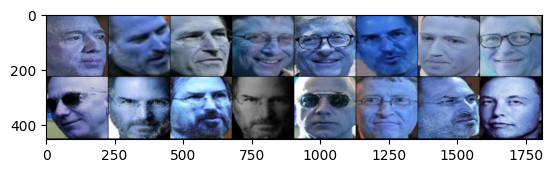

In [39]:
plt.imshow(img)

In [40]:
# Будем использовать модель vgg16

model = vgg16(pretrained = True)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи классификации
num_classes = 5
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [42]:
# Настроим 3 последних сверточных слоя сети
for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [43]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

False


In [44]:
dataloaders = {'train': train_loader,
                  'val': val_loader}

In [45]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидая 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(phase).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(phase).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [46]:
celebrities = train_model(model, device, dataloaders, criterion, optimizer,  batch_size=batch_size, num_epochs=1)

Epoch 0/0
----------
Batch 10, Train Loss:1.9159, Train ACC:26.8750
Batch 20, Train Loss:1.5254, Train ACC:40.3125
Batch 30, Train Loss:1.2795, Train ACC:53.1250
Batch 40, Train Loss:1.0773, Train ACC:61.0938
Batch 50, Train Loss:0.9173, Train ACC:67.1250
Batch 60, Train Loss:0.8256, Train ACC:71.3542
Batch 70, Train Loss:0.7659, Train ACC:73.3036
Batch 80, Train Loss:0.7059, Train ACC:75.5469
Batch 90, Train Loss:0.6795, Train ACC:77.1528
Batch 100, Train Loss:0.6584, Train ACC:78.1250
Batch 110, Train Loss:0.6205, Train ACC:79.4886
Batch 120, Train Loss:0.6008, Train ACC:80.5208
Batch 130, Train Loss:0.5930, Train ACC:81.2019
Batch 140, Train Loss:0.5828, Train ACC:81.4732
Batch 150, Train Loss:0.5731, Train ACC:81.9583
Batch 160, Train Loss:0.5460, Train ACC:82.7734
Batch 170, Train Loss:0.5249, Train ACC:83.4191
Batch 180, Train Loss:0.5223, Train ACC:83.8542
train Loss: 0.5140 Acc: 0.8417
val Loss: 0.4512 Acc: 0.9081
Время обучения: 4m 40s


In [49]:
classes = ["bill_gates", "elon_musk", 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    plt.figure()

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

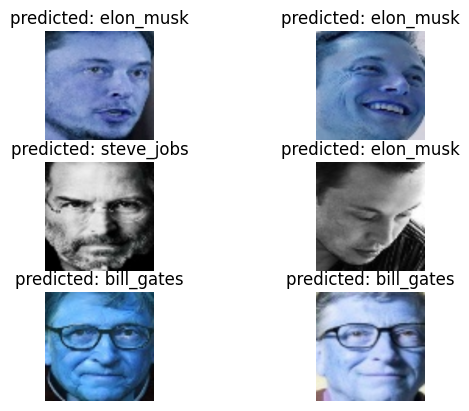

In [50]:
visualize_model(celebrities)
plt.show()

### Итог

Переобучив часть сверточных слоев и классификатор модели vgg16 на классификатор для 5 групп. Мы получили модель, которая имеет accauracy 0.84 на обучающей выборке и accaracy 0.9 на валидационной выборке. Модель не переобучена и имеет 90% вероятность различить 5 различных знаменитостей.